In [1]:
import os
from re import L
import sys
sys.path.append(os.path.abspath('..'))
print(os.path.abspath('..'))

/data/shizhaoshu/project/dltime-torch


In [11]:
import torch
import torch.nn as nn
import numpy as np
import time
import wandb
import gc
import pandas as pd
from train_helper import train_fn, valid_fn
from config import TrainConfig
from utils import get_logger, get_optimizer_params, get_scheduler, load_pretrained_state_dict
from dltime.data.ts_datasets import Transformer_UCR_UEADataset
from dltime.data.tsc_dataset_names import multivariate_equal_length
from dltime.models.ts_transformer import TSTransformerEncoderClassifier, TSTransformerEncoder, TSTransformerEncoderMLM
from transformers import AdamW
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
CFG = TrainConfig()

In [4]:
def plot_mul_dim_series(series, plot=True, dim_name=None, save=False, save_name='test'):
    x = np.arange(len(series[0]))
    plt.figure(figsize=[20, 10])
    for i, s in enumerate(series[:-1]):
        if dim_name is not None:
            plt.plot(x, s, label=dim_name[i])
        else:
            plt.plot(x, s, label=f"dim {i}", )
    
    plt.plot(x, series[-1], label="attn", linestyle = 'dashdot', color = 'r', linewidth=2.0)
    plt.legend()
    if save:
        plt.savefig(f"./outputs/analyse_pic/{save_name}.jpg")
    if plot:
        plt.show()

In [5]:
dataset_name = "ArticularyWordRecognition"
train_dataset = Transformer_UCR_UEADataset(dataset_name, split="train")
test_dataset = Transformer_UCR_UEADataset(dataset_name, split="test")

In [6]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [7]:
train_labels = [item['label'].item() for item in train_dataset]
test_labels = [item['label'].item() for item in test_dataset]

In [8]:
feat_dim = train_dataset[0]['input'].shape[-1]
max_len = train_dataset.max_len
num_classes = len(train_dataset.y2label)

Attention

In [12]:
num_layers = 2
model = TSTransformerEncoderClassifier(
        feat_dim=feat_dim, 
        max_len=max_len,
        d_model=128, n_heads=2, num_layers=2, 
        dim_feedforward=512, num_classes=num_classes).to(CFG.device)

lm_model = TSTransformerEncoderMLM(
        feat_dim=feat_dim, 
        max_len=max_len,
        d_model=128, n_heads=2, num_layers=2, 
        dim_feedforward=512).to(CFG.device)

encoder = TSTransformerEncoder(
        feat_dim=feat_dim,
        max_len=max_len,
        d_model=128,
        n_heads=2,
        num_layers=1,
        dim_feedforward=512).to(CFG.device)

self_attn = nn.MultiheadAttention(embed_dim=128, num_heads=2, dropout=0.1).to(CFG.device)

In [16]:
# load model
lm_model.load_state_dict(torch.load(f"./outputs/{dataset_name}_best.pth"))

<All keys matched successfully>

In [18]:
model_dict = model.state_dict()
lm_model_dict = lm_model.state_dict()
encoder_dict = encoder.state_dict()
self_attn_dict = self_attn.state_dict()

In [19]:
# load encoder
for name, parameter in encoder_dict.items():
    encoder_dict[name] = lm_model_dict[name]

# load last state self-atten
for name, parameter in self_attn_dict.items():
    self_attn_dict[name] = lm_model_dict[f'transformer_encoder.layers.{num_layers-1}.self_attn.' + name]

encoder.load_state_dict(encoder_dict)
self_attn.load_state_dict(self_attn_dict)

<All keys matched successfully>

In [20]:
def inference_fn(dataloader, model, encoder, self_attn, device):
    preds = []
    weights = []
    model.eval()
    encoder.eval()
    self_attn.eval()
    tk0 = tqdm(dataloader, total=len(dataloader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device).squeeze()
        with torch.no_grad():
            encode_features = encoder(inputs['input'], inputs['padding_mask'])
            attn_weight = self_attn(encode_features, encode_features, encode_features, key_padding_mask=inputs['padding_mask'])[1]
            y_preds = model(inputs['input'], inputs['padding_mask'])
        
        preds.append(y_preds.argmax(dim=-1).cpu().numpy())
        weights.append(attn_weight.cpu().numpy())
    predictions = np.concatenate(preds)
    attn_weights = np.concatenate(weights)
    return predictions, attn_weights

def inference_lm_fn(dataloader, encoder, self_attn, device):
    weights = []
    encoder.eval()
    self_attn.eval()
    tk0 = tqdm(dataloader, total=len(dataloader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device).squeeze()
        with torch.no_grad():
            encode_features = encoder(inputs['input'], inputs['padding_mask'])
            attn_weight = self_attn(encode_features, encode_features, encode_features, key_padding_mask=inputs['padding_mask'])[1]

        weights.append(attn_weight.cpu().numpy())
    attn_weights = np.concatenate(weights)
    
    return attn_weights

In [22]:
# train_preds, train_weights = inference_fn(train_loader, model, encoder, self_attn, CFG.device)
# test_preds, test_weights = inference_fn(test_loader, model, encoder, self_attn, CFG.device)
train_weights = inference_lm_fn(train_loader, encoder, self_attn, CFG.device)
test_weights = inference_lm_fn(test_loader, encoder, self_attn, CFG.device)

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


In [34]:
train_weights[:, 0, 1]

array([0.00728629, 0.01379118, 0.00578686, 0.00831475, 0.00509364,
       0.00704853, 0.00679666, 0.00515856, 0.00407867, 0.01029554,
       0.00744118, 0.01284453, 0.03320843, 0.01852571, 0.01809939,
       0.01353522, 0.00739735, 0.00498452, 0.02075723, 0.01652718,
       0.02173518, 0.00727248, 0.01088246, 0.01156565, 0.01193055,
       0.00849636, 0.01038129, 0.00956332, 0.00997919, 0.01024672,
       0.01241593, 0.01138368, 0.01463758, 0.00719045, 0.00320974,
       0.00394023, 0.00597387, 0.00349366, 0.00369425, 0.00230089,
       0.00266539, 0.00556378, 0.00660681, 0.001857  , 0.00466023,
       0.00670439, 0.00777421, 0.00558963, 0.00472207, 0.00790338,
       0.00700529, 0.00543473, 0.00614234, 0.00716591, 0.00415881,
       0.00349728, 0.00336013, 0.00269597, 0.00303829, 0.00400995,
       0.00382518, 0.00322312, 0.00428759, 0.00344263, 0.00310085,
       0.00379274, 0.01006476, 0.00874353, 0.00849349, 0.00683945,
       0.00959336, 0.00933967, 0.00780931, 0.00843513, 0.01192

In [33]:
train_weights[:, 0, 0]

array([0.00954311, 0.01097628, 0.01012722, 0.01204002, 0.01040978,
       0.01011878, 0.00962552, 0.01021517, 0.01445177, 0.01004948,
       0.01012169, 0.00976822, 0.00909925, 0.00939684, 0.0121691 ,
       0.00907862, 0.00996574, 0.01088217, 0.00860307, 0.00906804,
       0.00702652, 0.01167082, 0.00697653, 0.00767748, 0.00765564,
       0.00833724, 0.00797   , 0.0085171 , 0.00735598, 0.00734776,
       0.00756565, 0.00778747, 0.00735624, 0.01208054, 0.01107194,
       0.01192396, 0.01110741, 0.01038598, 0.01029441, 0.01003563,
       0.01157344, 0.01405506, 0.01135358, 0.00923531, 0.01209282,
       0.01133399, 0.01023637, 0.01202756, 0.01023126, 0.0104206 ,
       0.01077384, 0.01089293, 0.01052229, 0.01030972, 0.01065262,
       0.01152942, 0.01088012, 0.01039896, 0.00864788, 0.01134259,
       0.01248228, 0.01038195, 0.01207025, 0.01051   , 0.01078826,
       0.01070656, 0.01264862, 0.01106406, 0.01307554, 0.01414592,
       0.01330202, 0.01364111, 0.01329984, 0.01354758, 0.01357

In [23]:
def soft_max(x):
    z = np.array(x) - np.max(x)
    t = np.exp(z)
    a = np.exp(z) / np.sum(t)
    return a

def min_max(x):
    z = np.array(x) - np.min(x)
    return z / (np.max(x) - np.min(x))

In [24]:
def visual_one_case(idx, dataset, weights, plot=True, save=False, save_name='test'):
    case0 = dataset[idx]['input'].detach().cpu().numpy().tolist()
    case0 = [case for case in case0 if case != [1.0] * len(case0[0]) and case != [0.0] * len(case0[0])]
    visual_case = []
    for i in range(len(case0[0])):
        visual_case.append([case[i] for case in case0])
    
    weight = min_max(weights[idx, 0, 1: 1+len(case0)])
    visual_case.append(weight)
    plot_mul_dim_series(visual_case, plot=plot, save=save, save_name=save_name)

0


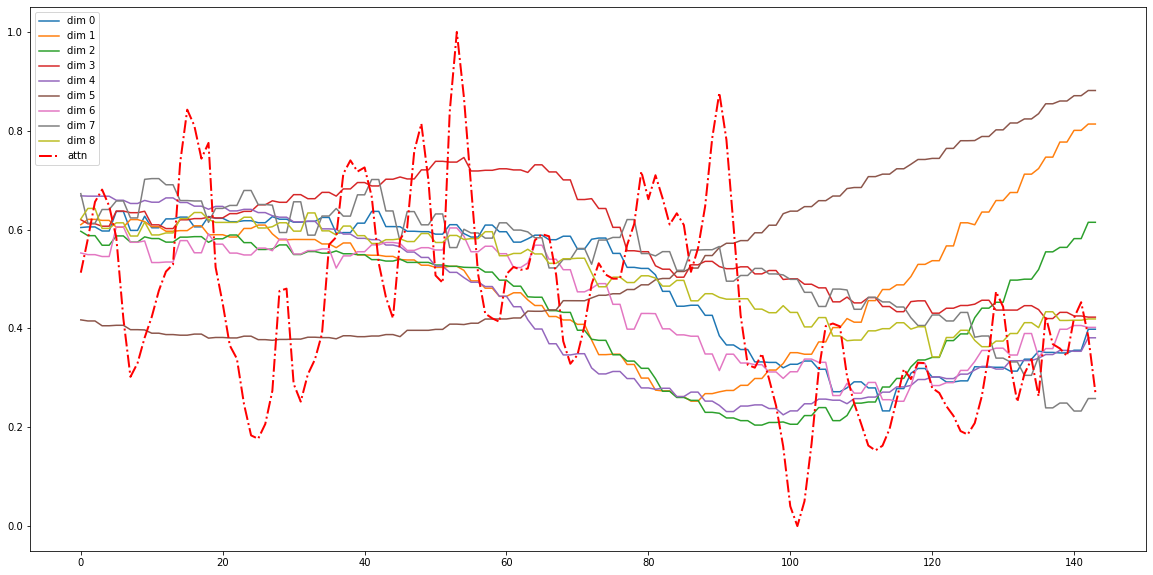

In [35]:
idx = 0
print(train_labels[idx])
visual_one_case(idx, train_dataset, train_weights)

11


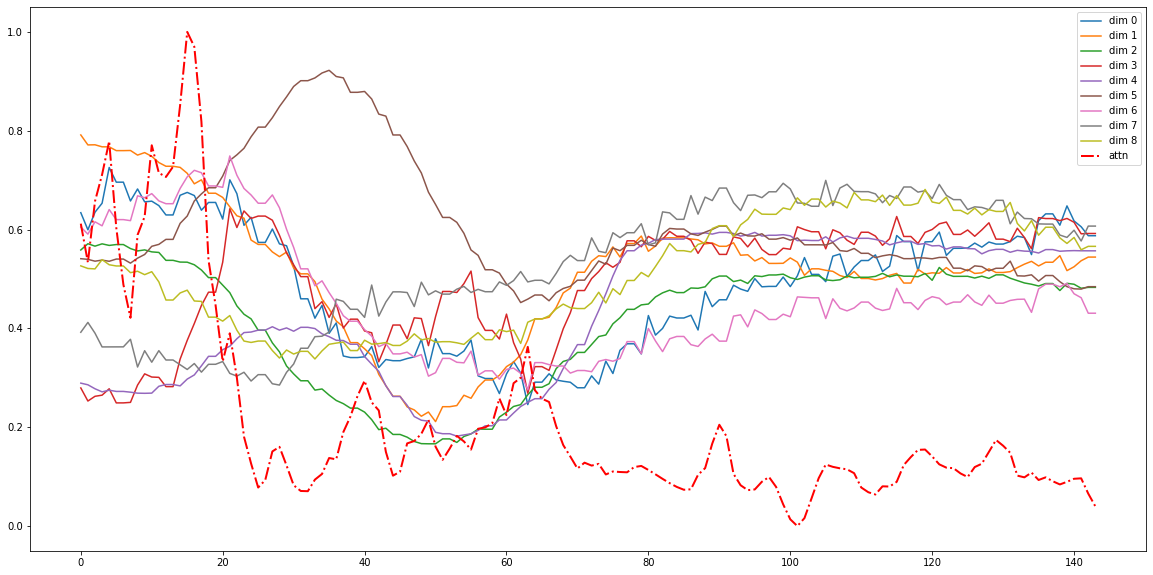

In [32]:
idx = 22
print(test_labels[idx])
visual_one_case(idx, test_dataset, test_weights, save=False, \
    save_name=f'{dataset_name}_test_{idx}_label{test_labels[idx]}_pred')

In [107]:
train_labels[63]

2

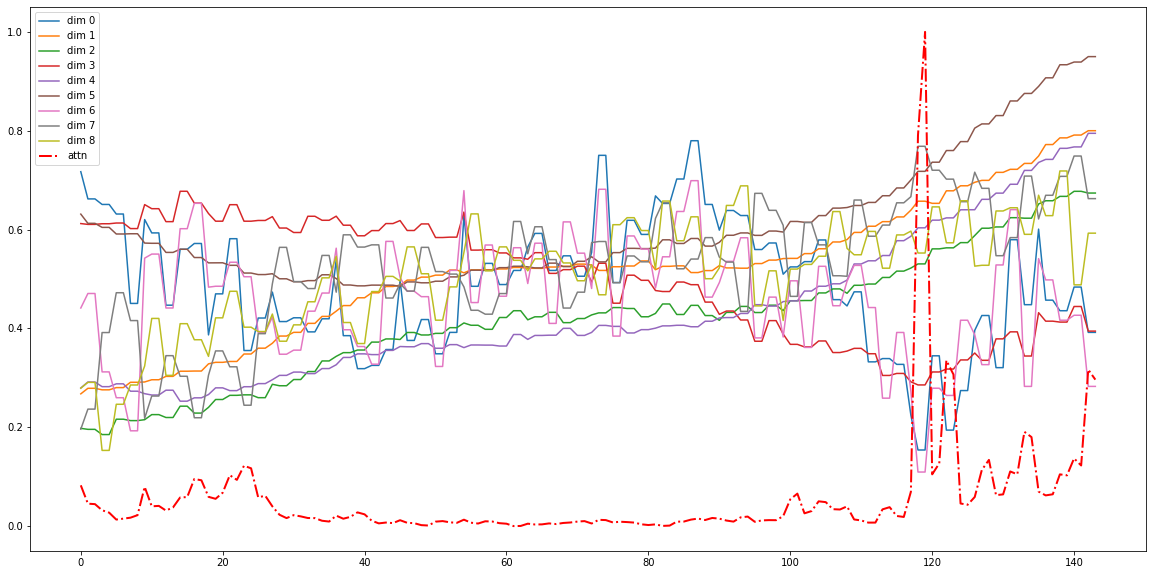

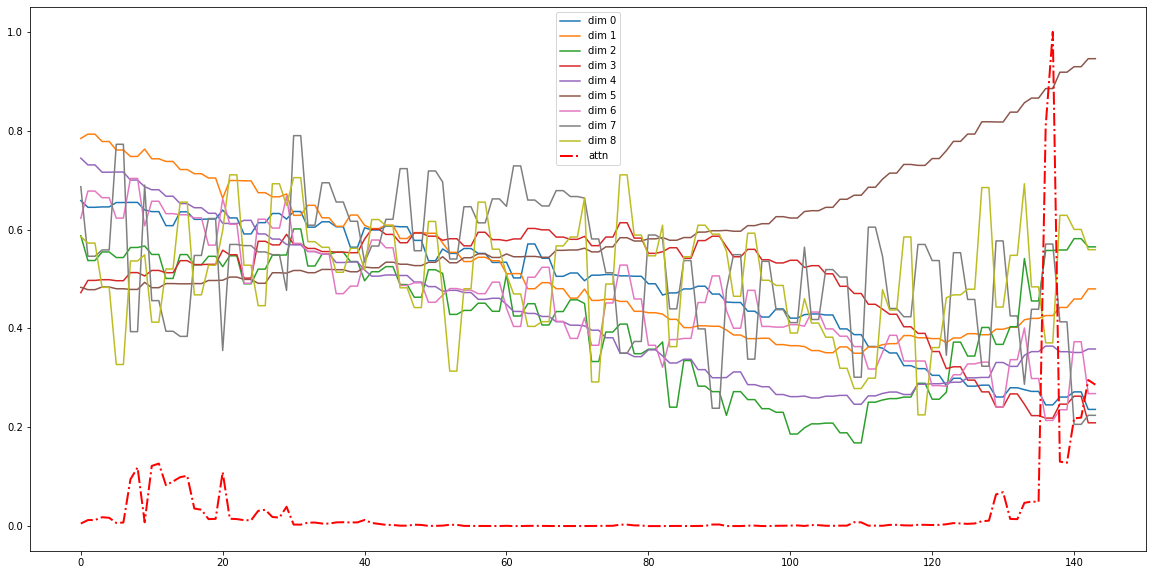

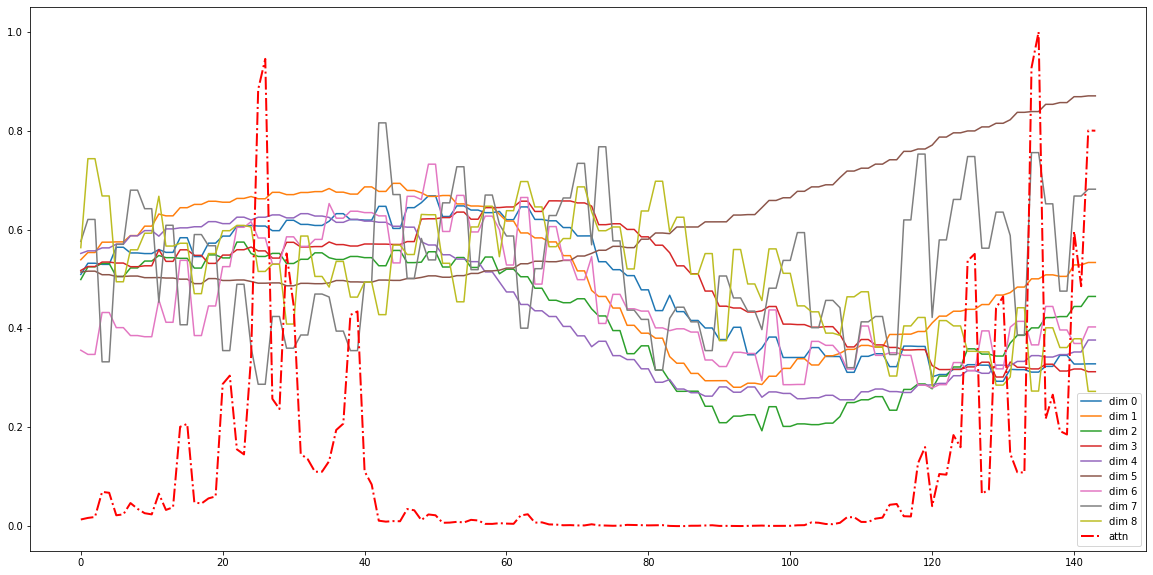

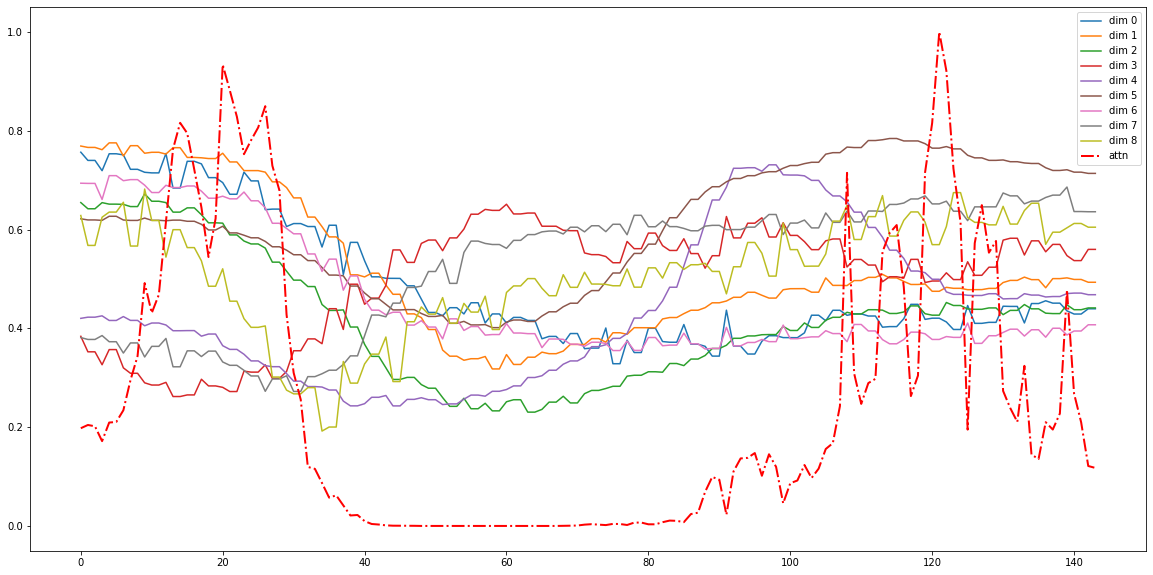

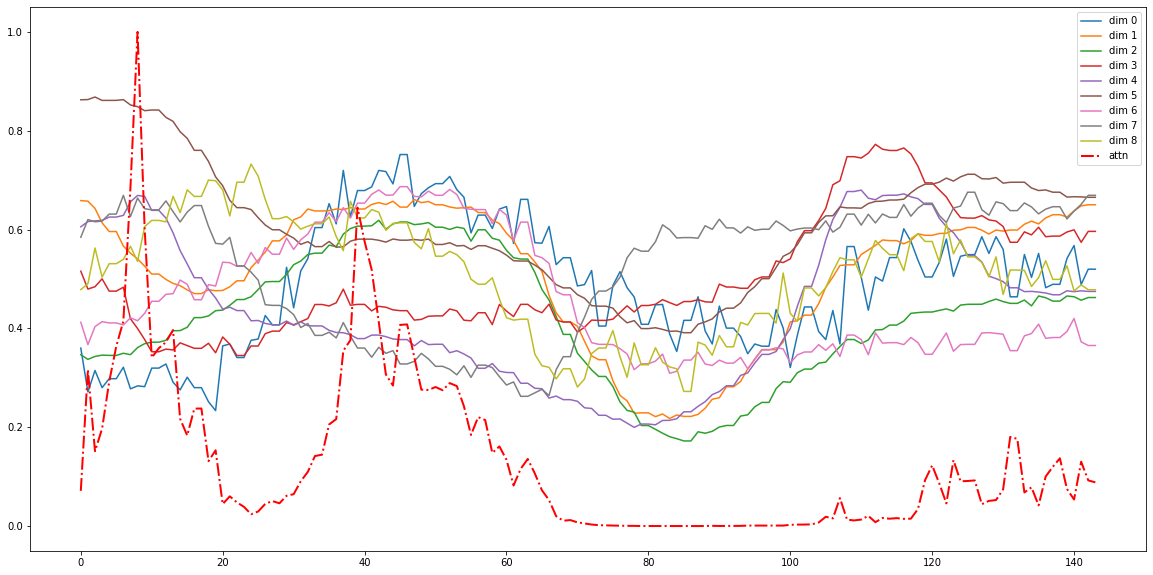

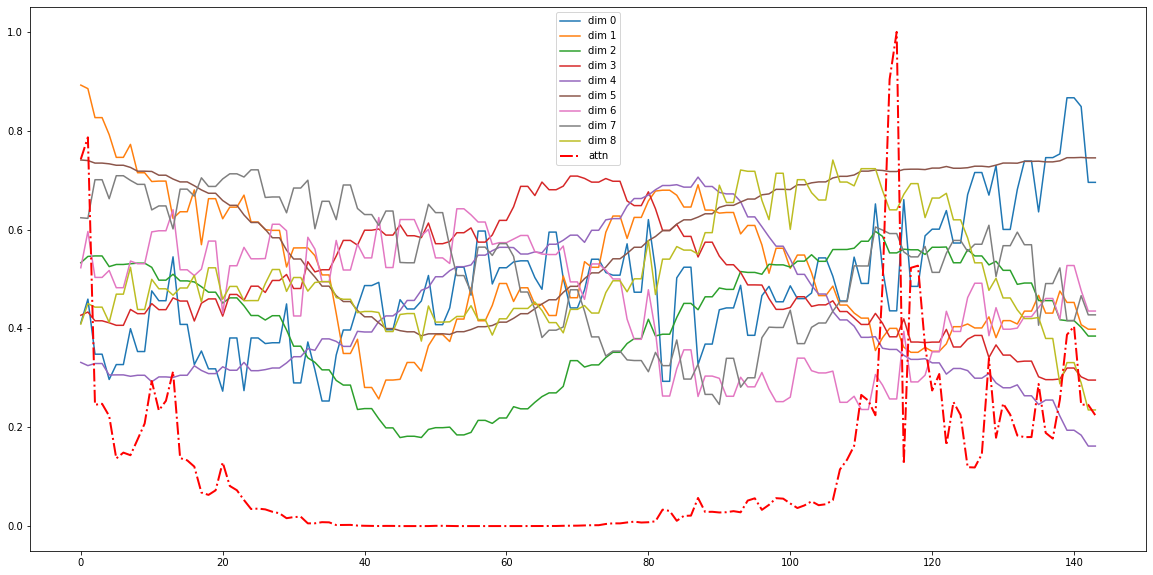

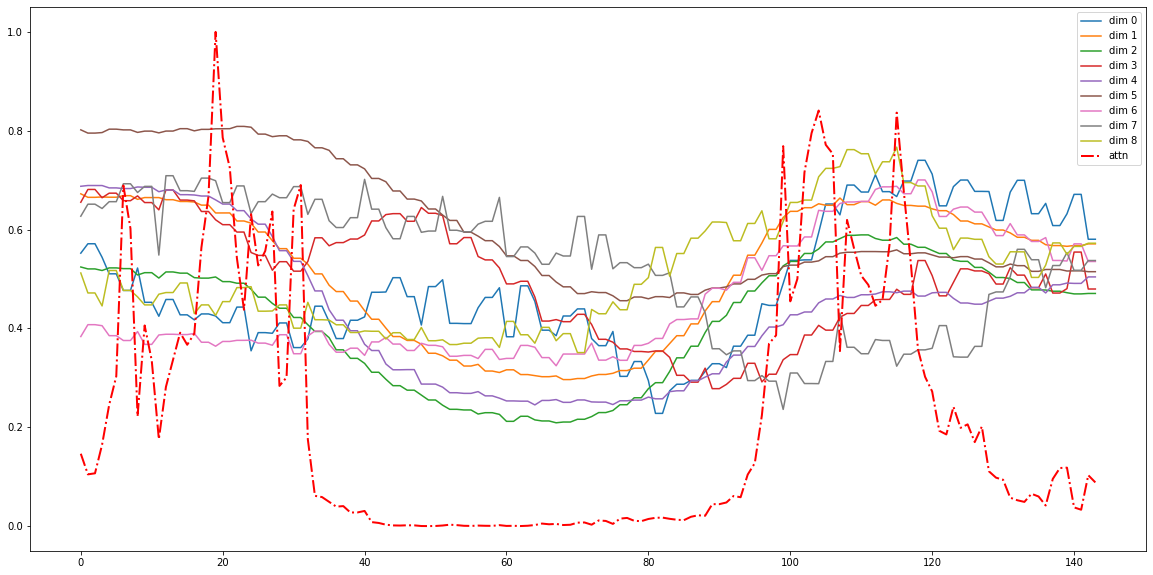

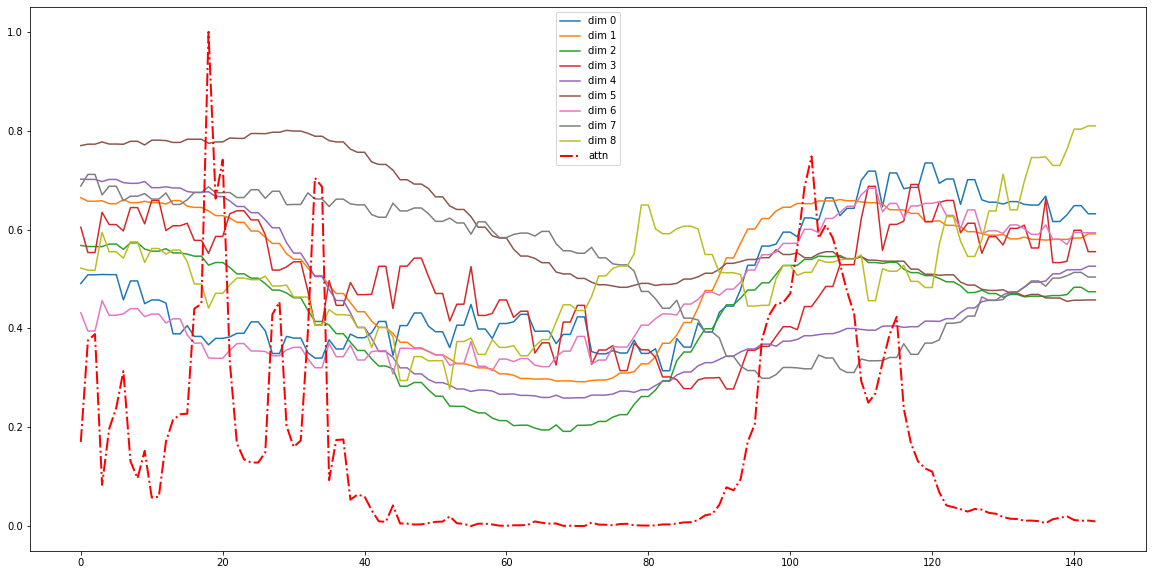

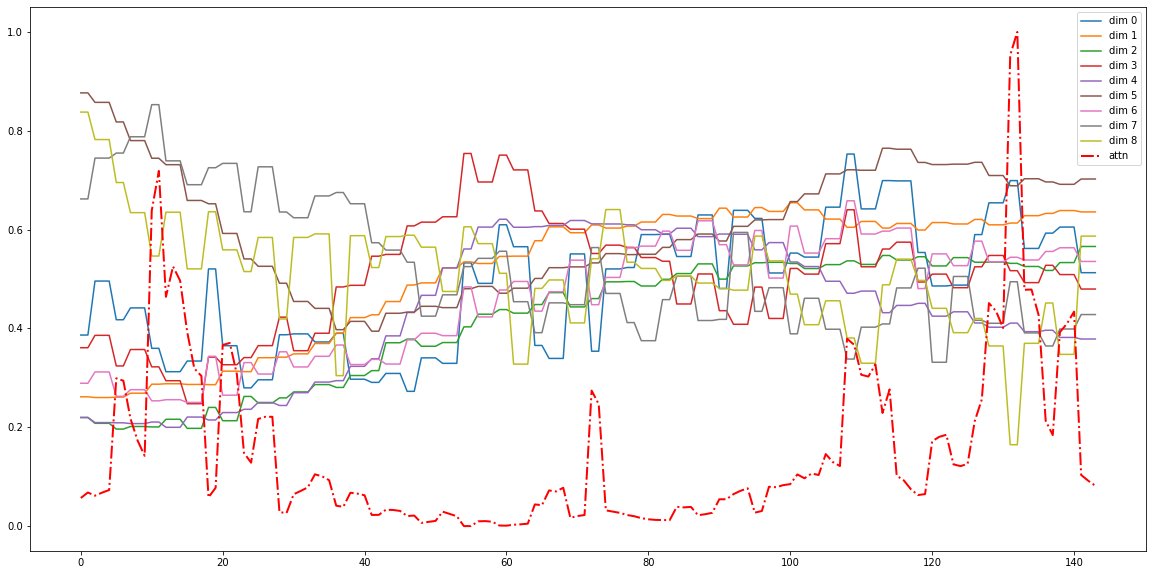

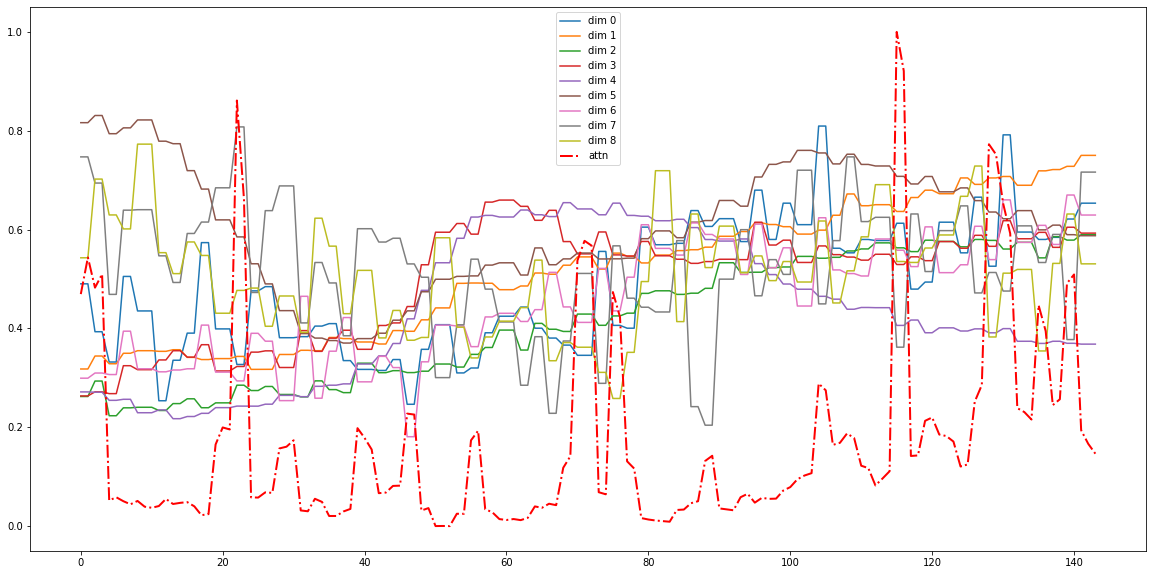

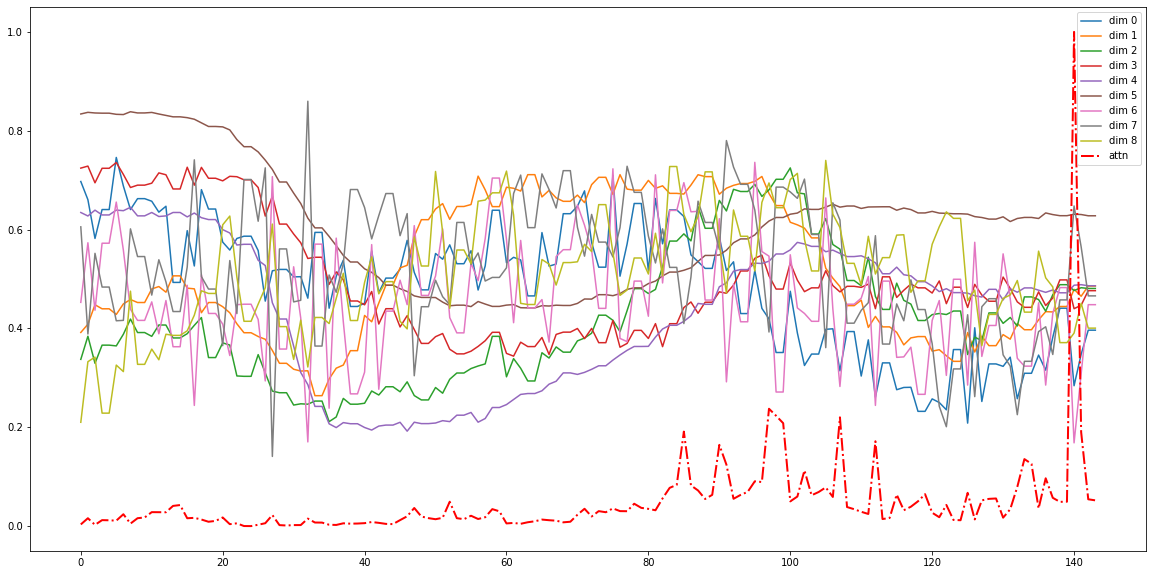

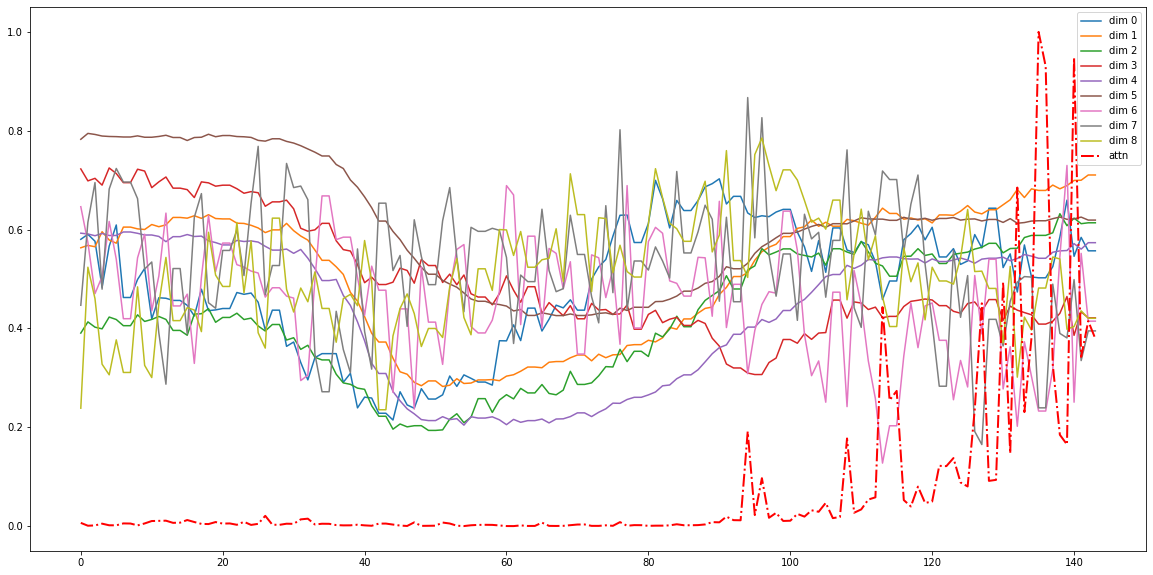

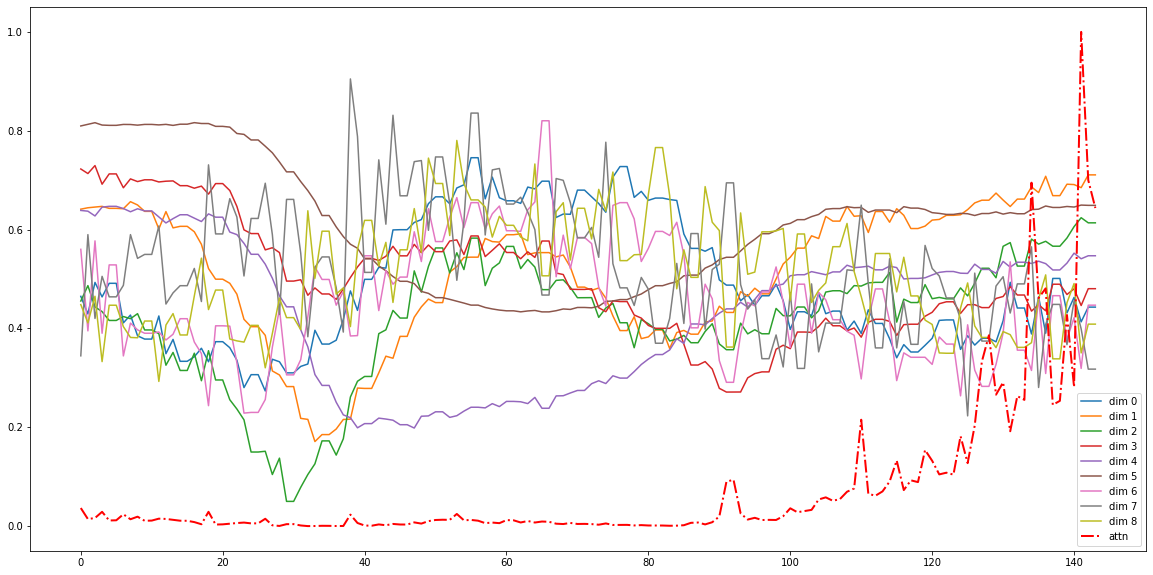

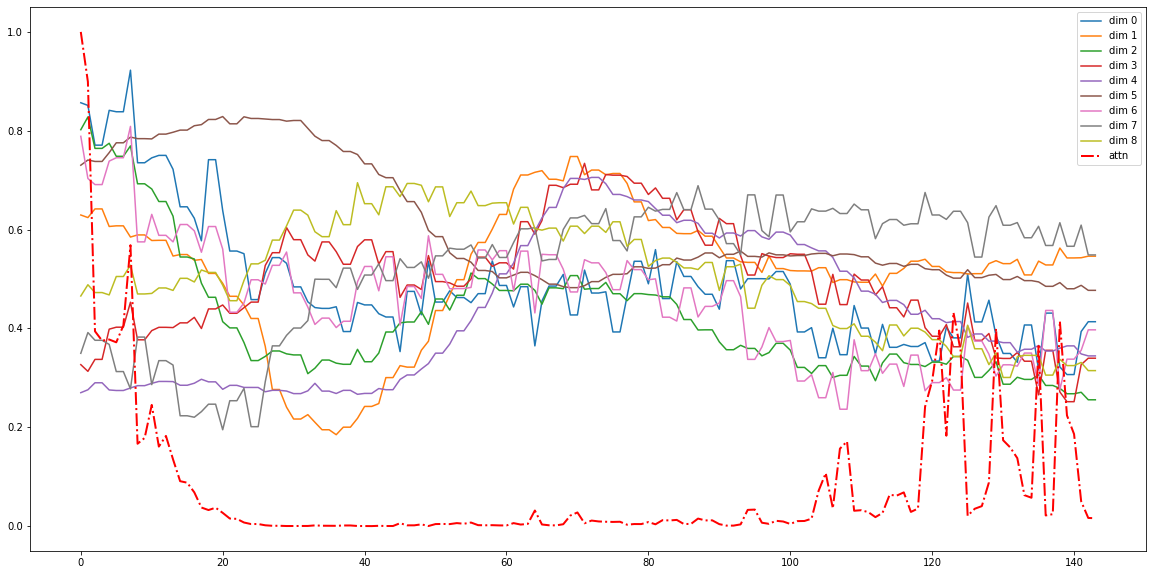

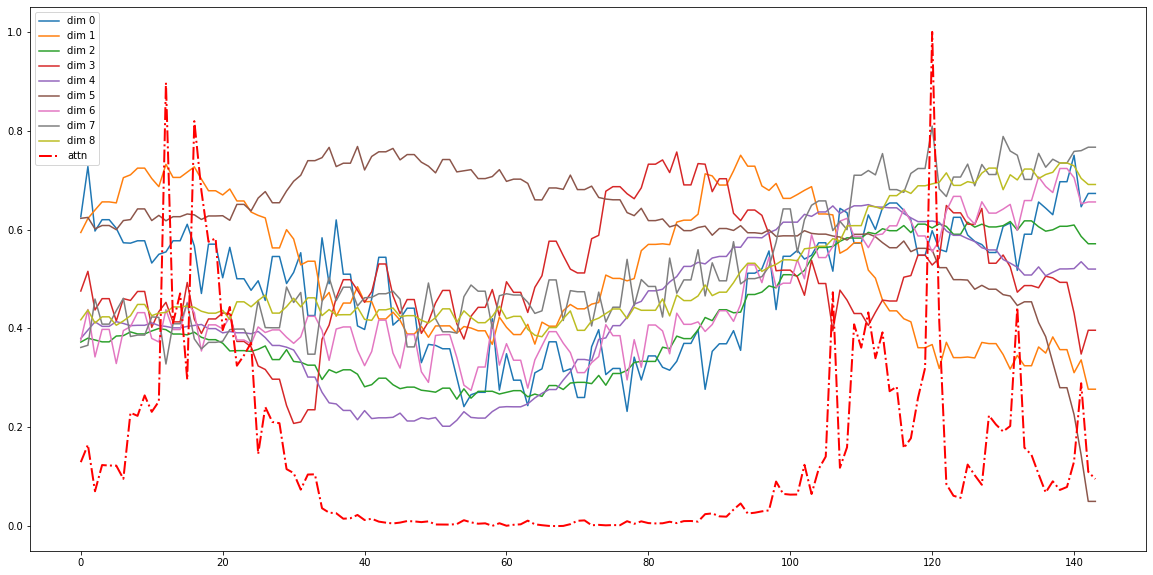

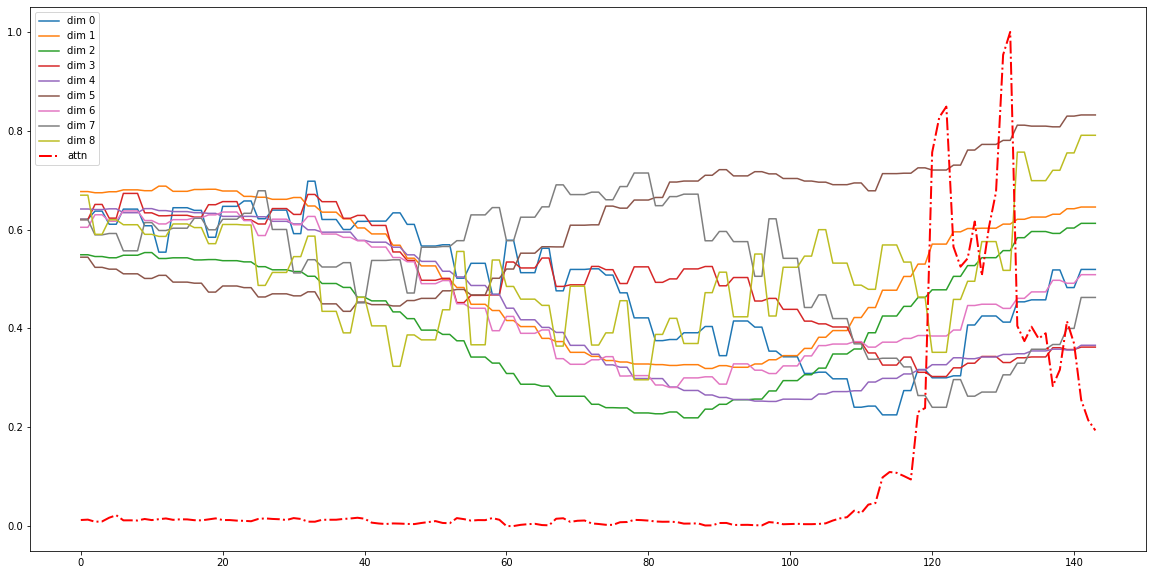

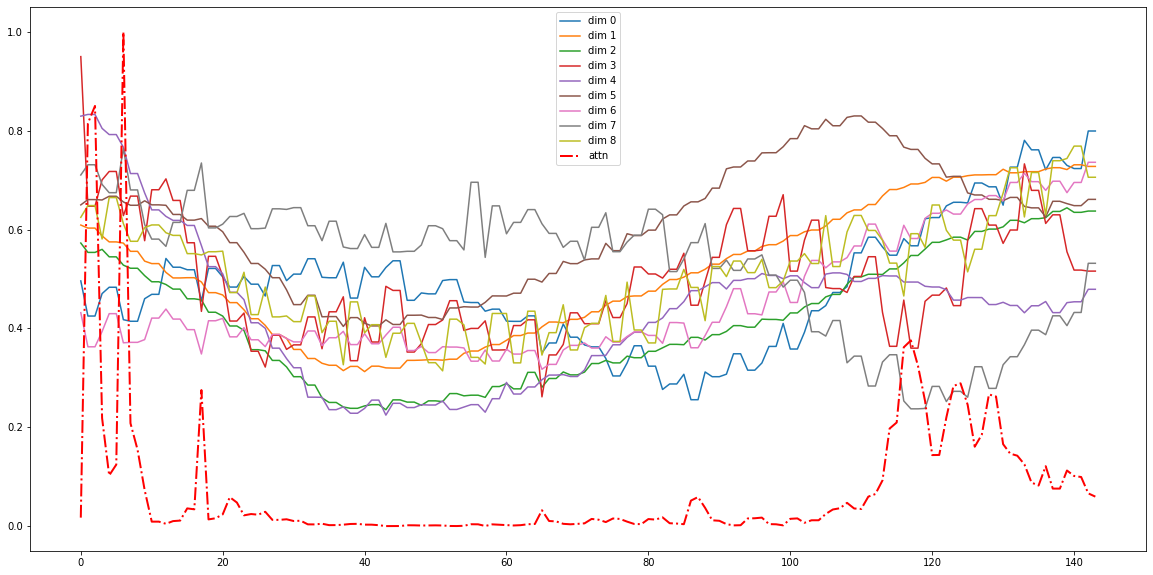

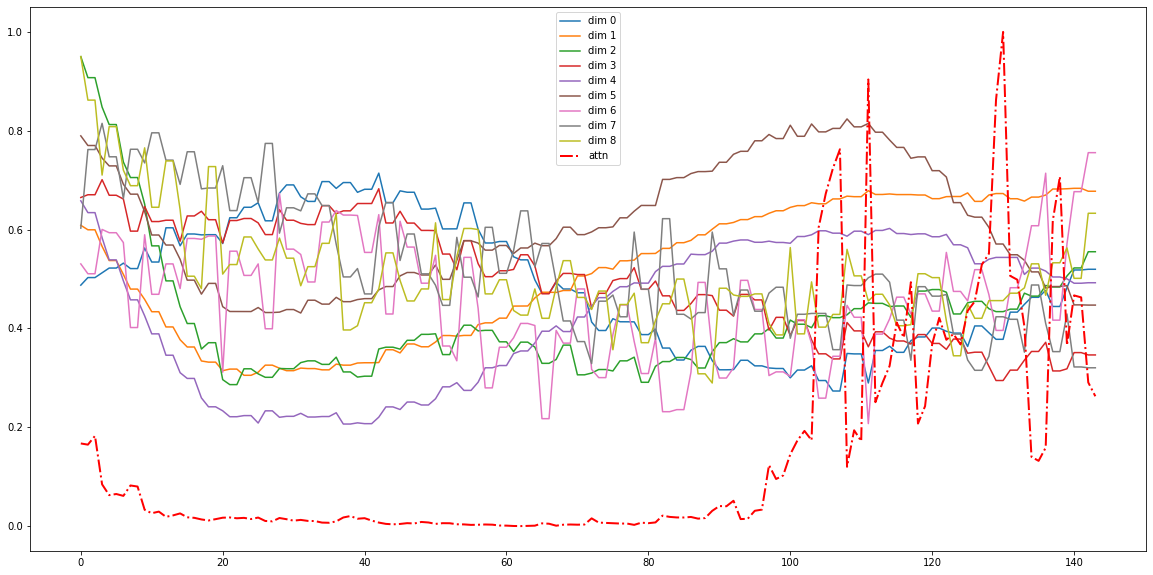

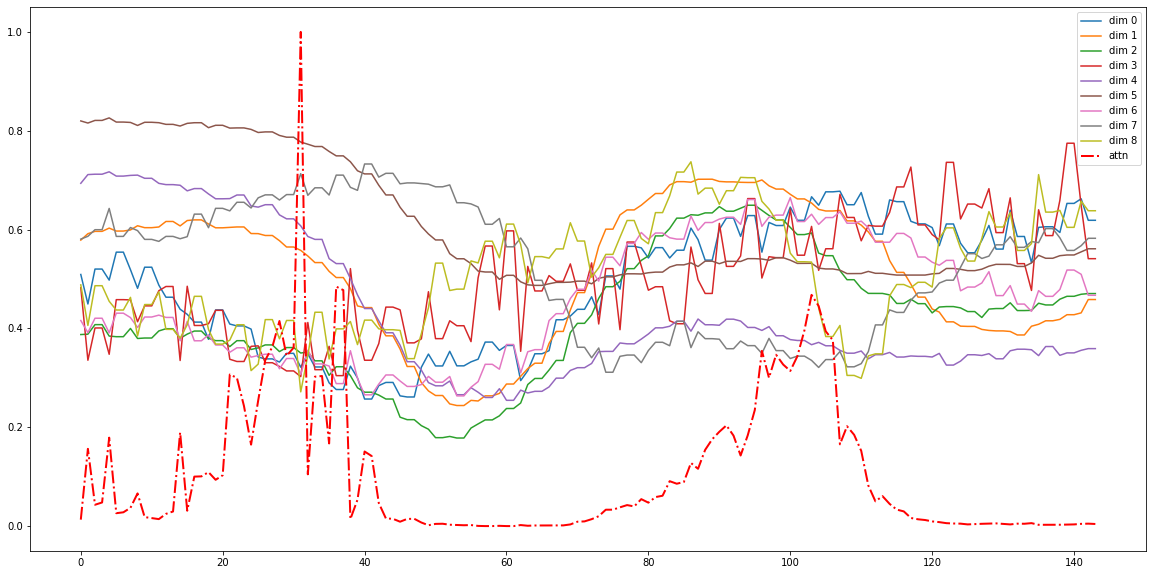

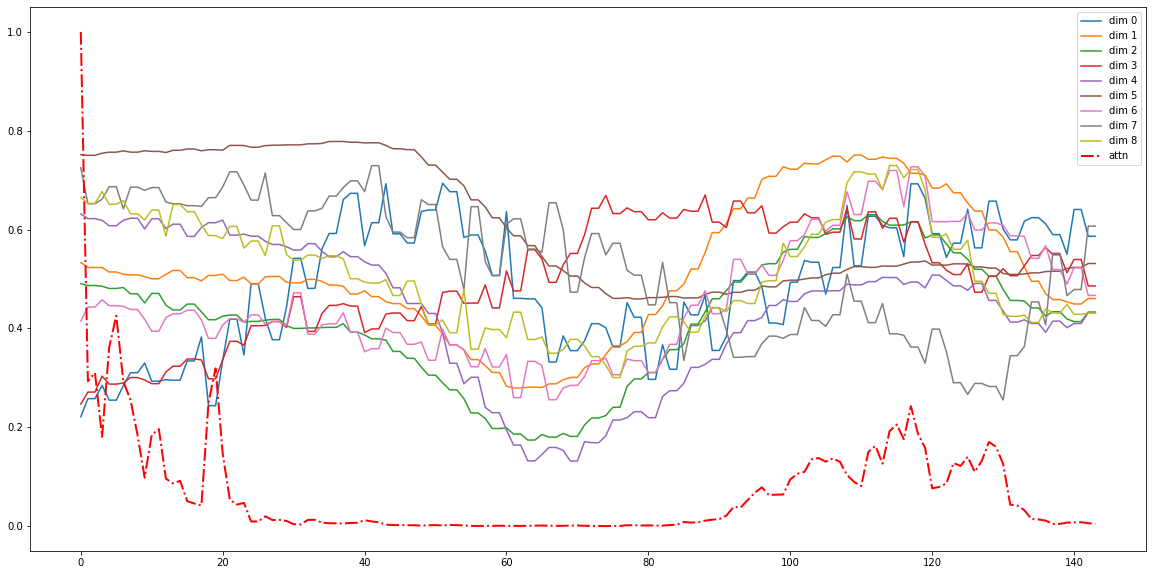

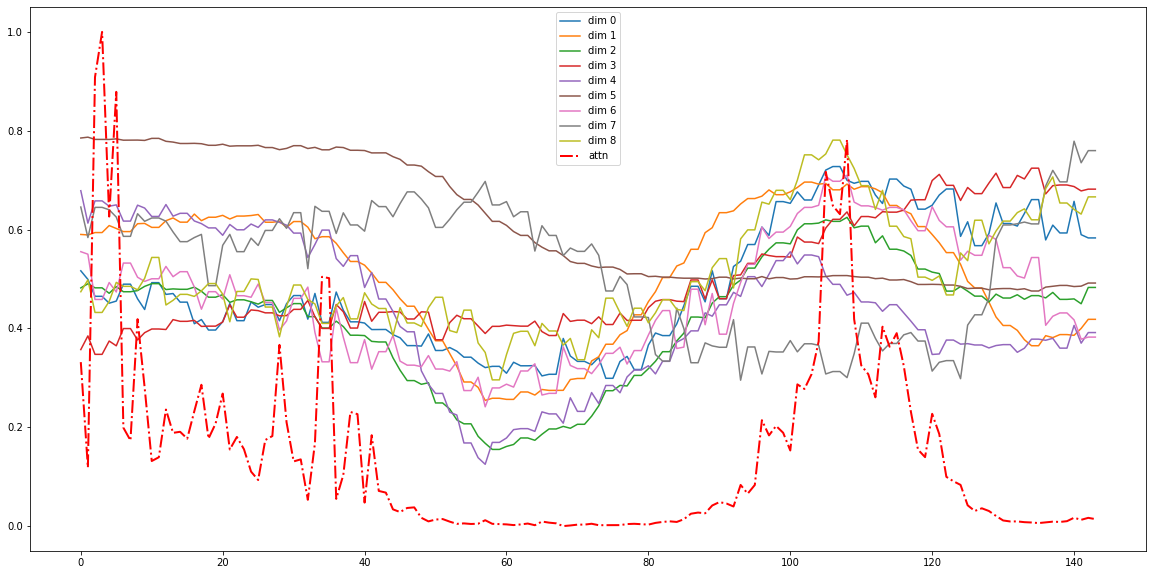

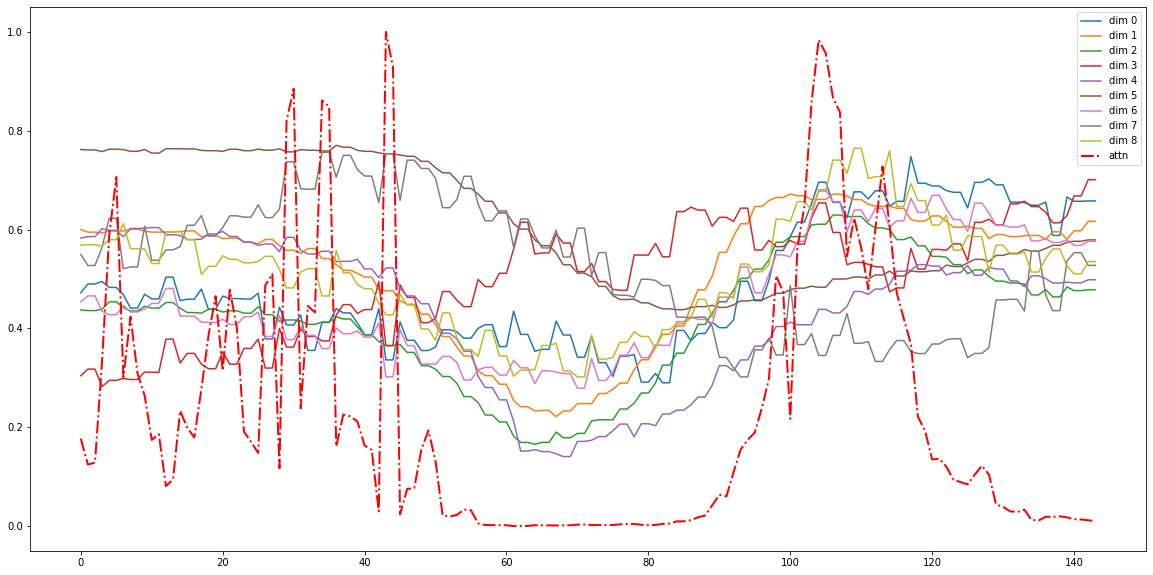

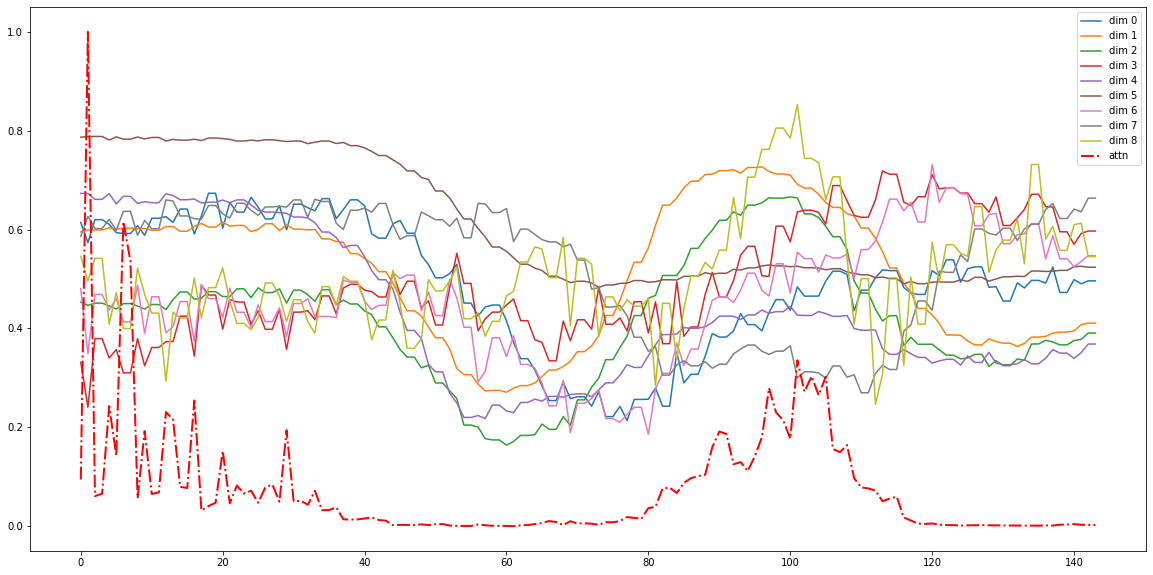

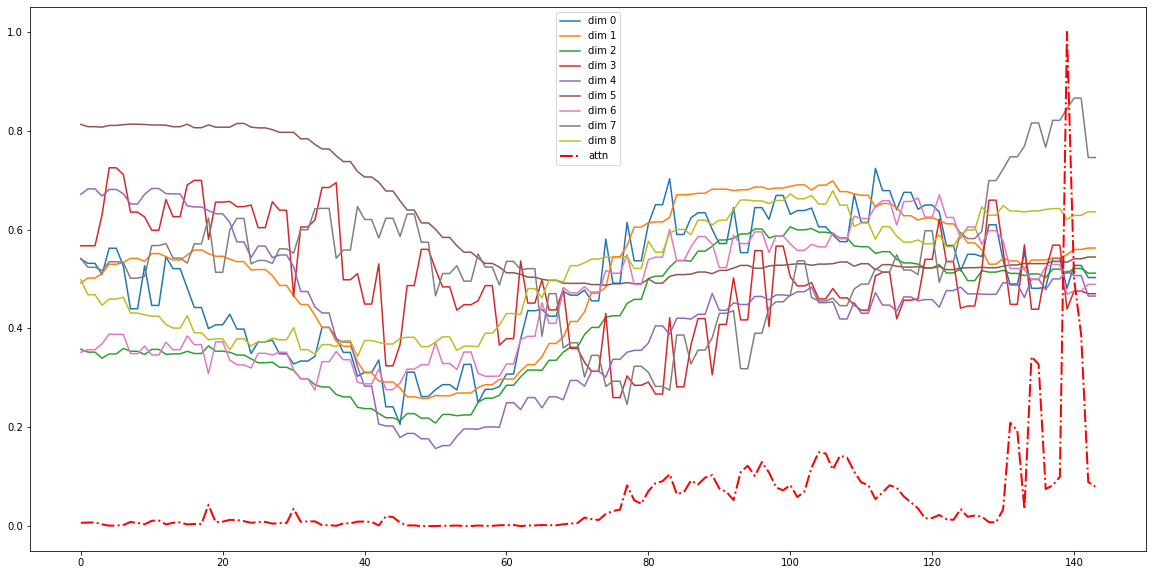

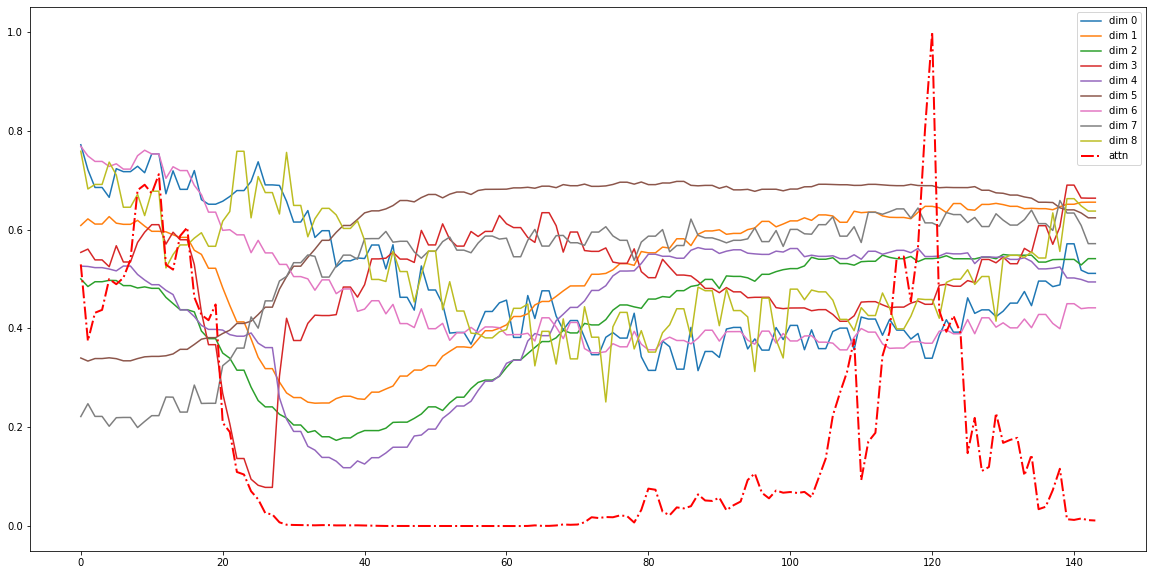

In [60]:
for i, (label, pred) in enumerate(zip(test_labels, test_preds)):
    if label != pred:
        visual_one_case(i, test_dataset, test_weights, save=True, \
            save_name=f'{dataset_name}_test_{idx}_label{label}_pred{pred}')